# REST API ETL Data Pipeline

## Start Spark Session

In [ ]:
# Install Pyspark

!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys

import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, explode, create_map, countDistinct

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,845 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,083 kB]
Fetched 3,156 kB in 2s (1,910 kB/s)
Reading package lists... Done
Bui

In [ ]:
#Start a Spark Session

spark = SparkSession.builder.appName("IMPORTAPI").getOrCreate()
sqlContext = SparkSession(spark)

#Set log level to show error not warning

spark.sparkContext.setLogLevel("ERROR")

## Ingest Data from API

In [ ]:
#import package for calling API and formating JSON
import requests
import json

url = 'https://api.usaspending.gov/api/v2/references/toptier_agencies/'
response = requests.request("GET", url)


json_text = json.loads(response.text)
print(json_text)

{'results': [{'agency_id': 1146, 'toptier_code': '310', 'abbreviation': 'USAB', 'agency_name': 'Access Board', 'congressional_justification_url': 'https://www.access-board.gov/cj', 'active_fy': '2024', 'active_fq': '2', 'outlay_amount': 4681943.03, 'obligated_amount': 3595310.05, 'budget_authority_amount': 12466997.7, 'current_total_budget_authority_amount': 13865505067157.33, 'percentage_of_total_budget_authority': 8.991376541724455e-07, 'agency_slug': 'access-board'}, {'agency_id': 1136, 'toptier_code': '302', 'abbreviation': 'ACUS', 'agency_name': 'Administrative Conference of the U.S.', 'congressional_justification_url': 'https://www.acus.gov/cj', 'active_fy': '2024', 'active_fq': '2', 'outlay_amount': 0.0, 'obligated_amount': 0.0, 'budget_authority_amount': 0.0, 'current_total_budget_authority_amount': 13865505067157.33, 'percentage_of_total_budget_authority': 0.0, 'agency_slug': 'administrative-conference-of-the-us'}, {'agency_id': 1144, 'toptier_code': '306', 'abbreviation': 'AC

In [ ]:
# select data in dictionary

json_data = json_text["results"]

json_data

[{'agency_id': 1146,
  'toptier_code': '310',
  'abbreviation': 'USAB',
  'agency_name': 'Access Board',
  'congressional_justification_url': 'https://www.access-board.gov/cj',
  'active_fy': '2024',
  'active_fq': '2',
  'outlay_amount': 4681943.03,
  'obligated_amount': 3595310.05,
  'budget_authority_amount': 12466997.7,
  'current_total_budget_authority_amount': 13865505067157.33,
  'percentage_of_total_budget_authority': 8.991376541724455e-07,
  'agency_slug': 'access-board'},
 {'agency_id': 1136,
  'toptier_code': '302',
  'abbreviation': 'ACUS',
  'agency_name': 'Administrative Conference of the U.S.',
  'congressional_justification_url': 'https://www.acus.gov/cj',
  'active_fy': '2024',
  'active_fq': '2',
  'outlay_amount': 0.0,
  'obligated_amount': 0.0,
  'budget_authority_amount': 0.0,
  'current_total_budget_authority_amount': 13865505067157.33,
  'percentage_of_total_budget_authority': 0.0,
  'agency_slug': 'administrative-conference-of-the-us'},
 {'agency_id': 1144,
  't

In [ ]:
len(json_data)

108

In [ ]:
# create dataframe from json
df_api = spark.createDataFrame(data=json_data)

df_api

DataFrame[abbreviation: string, active_fq: string, active_fy: string, agency_id: bigint, agency_name: string, agency_slug: string, budget_authority_amount: double, congressional_justification_url: string, current_total_budget_authority_amount: double, obligated_amount: double, outlay_amount: double, percentage_of_total_budget_authority: double, toptier_code: string]

In [ ]:
df_api.printSchema()

root
 |-- abbreviation: string (nullable = true)
 |-- active_fq: string (nullable = true)
 |-- active_fy: string (nullable = true)
 |-- agency_id: long (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- agency_slug: string (nullable = true)
 |-- budget_authority_amount: double (nullable = true)
 |-- congressional_justification_url: string (nullable = true)
 |-- current_total_budget_authority_amount: double (nullable = true)
 |-- obligated_amount: double (nullable = true)
 |-- outlay_amount: double (nullable = true)
 |-- percentage_of_total_budget_authority: double (nullable = true)
 |-- toptier_code: string (nullable = true)



In [ ]:
df_api.show(20)

+--------------+---------+---------+---------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+-----------------+-----------------+------------------------------------+------------+
|  abbreviation|active_fq|active_fy|agency_id|         agency_name|         agency_slug|budget_authority_amount|congressional_justification_url|current_total_budget_authority_amount| obligated_amount|    outlay_amount|percentage_of_total_budget_authority|toptier_code|
+--------------+---------+---------+---------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+-----------------+-----------------+------------------------------------+------------+
|          USAB|        2|     2024|     1146|        Access Board|        access-board|           1.24669977E7|           https://www.acces...|                 1.386550506715733E13|       3595

## Transform Data

In [ ]:
# create temp or HIVE table

df_api.createOrReplaceTempView('tmp_dfapi')


In [ ]:
df_api.describe().show()

+-------+------------+---------+---------+-----------------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+--------------------+--------------------+------------------------------------+------------------+
|summary|abbreviation|active_fq|active_fy|        agency_id|         agency_name|         agency_slug|budget_authority_amount|congressional_justification_url|current_total_budget_authority_amount|    obligated_amount|       outlay_amount|percentage_of_total_budget_authority|      toptier_code|
+-------+------------+---------+---------+-----------------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+--------------------+--------------------+------------------------------------+------------------+
|  count|         108|      108|      108|              108|                 108|                 108|             

In [ ]:
df_api.dtypes

[('abbreviation', 'string'),
 ('active_fq', 'string'),
 ('active_fy', 'string'),
 ('agency_id', 'bigint'),
 ('agency_name', 'string'),
 ('agency_slug', 'string'),
 ('budget_authority_amount', 'double'),
 ('congressional_justification_url', 'string'),
 ('current_total_budget_authority_amount', 'double'),
 ('obligated_amount', 'double'),
 ('outlay_amount', 'double'),
 ('percentage_of_total_budget_authority', 'double'),
 ('toptier_code', 'string')]

In [ ]:

from pyspark.sql.functions import col

# List columns with double data type
double_columns = [column for column, data_type in df_api.dtypes if data_type == "double"]

# Generate SQL query to replace null values with 0 in double columns

sql_query = ", ".join([f"COALESCE({column}, 0) AS {column}" for column in df_api.columns])

# Execute SQL query and replace null values
df_api = spark.sql(f"SELECT {sql_query} FROM tmp_dfapi")


df_api.show()

+--------------+---------+---------+---------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+-----------------+-----------------+------------------------------------+------------+
|  abbreviation|active_fq|active_fy|agency_id|         agency_name|         agency_slug|budget_authority_amount|congressional_justification_url|current_total_budget_authority_amount| obligated_amount|    outlay_amount|percentage_of_total_budget_authority|toptier_code|
+--------------+---------+---------+---------+--------------------+--------------------+-----------------------+-------------------------------+-------------------------------------+-----------------+-----------------+------------------------------------+------------+
|          USAB|        2|     2024|     1146|        Access Board|        access-board|           1.24669977E7|           https://www.acces...|                 1.386550506715733E13|       3595

In [ ]:
df_api.createOrReplaceTempView('tmp_dfapi')

In [ ]:
double_columns

['budget_authority_amount',
 'current_total_budget_authority_amount',
 'obligated_amount',
 'outlay_amount',
 'percentage_of_total_budget_authority']

In [ ]:
# Find distinct elements in each column
for col in df_api.columns:
    query = f"SELECT COUNT(DISTINCT {col}) AS {col}_unique_count FROM tmp_dfapi"
    unique_count_df = spark.sql(query)
    unique_count_df.show()

+-------------------------+
|abbreviation_unique_count|
+-------------------------+
|                      108|
+-------------------------+

+----------------------+
|active_fq_unique_count|
+----------------------+
|                     1|
+----------------------+

+----------------------+
|active_fy_unique_count|
+----------------------+
|                     1|
+----------------------+

+----------------------+
|agency_id_unique_count|
+----------------------+
|                   108|
+----------------------+

+------------------------+
|agency_name_unique_count|
+------------------------+
|                     108|
+------------------------+

+------------------------+
|agency_slug_unique_count|
+------------------------+
|                     108|
+------------------------+

+------------------------------------+
|budget_authority_amount_unique_count|
+------------------------------------+
|                                  96|
+------------------------------------+

+------------

In [ ]:
#create dataframe with outlay_amount

outlay_df = sqlContext.sql("""SELECT agency_name, outlay_amount
FROM tmp_dfapi
ORDER BY outlay_amount DESC
LIMIT 10;""")



In [ ]:
outlay_df.show()

+--------------------+-------------------+
|         agency_name|      outlay_amount|
+--------------------+-------------------+
|Department of Hea...|1.16435953677247E12|
|Department of the...| 8.6772755554378E11|
|Social Security A...| 7.7921100720142E11|
|Department of Def...| 6.8578152767764E11|
|Department of Vet...|   1.59184859633E11|
|Department of Agr...| 1.2345633208436E11|
|Office of Personn...|   9.96657443567E10|
|Department of Edu...|  8.191560976164E10|
|Federal Deposit I...|  6.805022596206E10|
|Department of Hom...|  5.998106645421E10|
+--------------------+-------------------+



In [ ]:
#create dataframe with budget_authority_amount

bauthority_df = sqlContext.sql("""SELECT agency_name, budget_authority_amount
FROM tmp_dfapi
ORDER BY budget_authority_amount DESC
LIMIT 10;""")

In [ ]:
bauthority_df.show()

+--------------------+-----------------------+
|         agency_name|budget_authority_amount|
+--------------------+-----------------------+
|Department of the...|    4.99352780646228E12|
|Department of Hea...|    2.82641103909564E12|
|Department of Def...|    2.02156038500998E12|
|Social Security A...|     8.4884916994171E11|
|Department of Vet...|      4.079117535718E11|
|Department of Agr...|     3.9022554669652E11|
|Office of Personn...|     3.4338310542926E11|
|Department of Tra...|     2.7221184823581E11|
|Department of Hou...|     2.5914817292305E11|
|Federal Deposit I...|     1.6211567601229E11|
+--------------------+-----------------------+



In [ ]:
#create dataframe with percentage_of_total_budget_authority

bpercent_df = sqlContext.sql("""SELECT agency_name, percentage_of_total_budget_authority
FROM tmp_dfapi
ORDER BY percentage_of_total_budget_authority DESC;""")

bpercent_df.show(20)

+--------------------+------------------------------------+
|         agency_name|percentage_of_total_budget_authority|
+--------------------+------------------------------------+
|Department of the...|                  0.3601403470177405|
|Department of Hea...|                  0.2038447950800182|
|Department of Def...|                 0.14579781805412698|
|Social Security A...|                 0.06122021273875881|
|Department of Vet...|                  0.0294191774187876|
|Department of Agr...|                 0.02814362295541846|
|Office of Personn...|                 0.02476527928597552|
|Department of Tra...|                0.019632306714927203|
|Department of Hou...|                0.018690135820359256|
|Federal Deposit I...|                0.011692013758394345|
|Department of Energy|                0.011575554670165756|
|Department of Hom...|                 0.01100912054523848|
|Department of Edu...|                0.008034729443588894|
|Department of Com...|                0.

In [ ]:
# Calculate spendout rate and create a new DataFrame
spendout_rate_df = sqlContext.sql("""
    SELECT
        agency_name,
        budget_authority_amount,
        outlay_amount,
        CASE WHEN budget_authority_amount != 0
             THEN (outlay_amount / budget_authority_amount)*100
             ELSE NULL
        END AS spendout_rate
    FROM tmp_dfapi
""")


spendout_rate_df.show(10)

+--------------------+-----------------------+---------------+------------------+
|         agency_name|budget_authority_amount|  outlay_amount|     spendout_rate|
+--------------------+-----------------------+---------------+------------------+
|        Access Board|           1.24669977E7|     4681943.03|37.554695546306235|
|Administrative Co...|                    0.0|            0.0|              NULL|
|Advisory Council ...|          1.412669329E7|     5513565.28| 39.02941167345186|
|African Developme...|          7.065302245E7|   1.64716374E7|23.313422170518905|
|Agency for Intern...|      2.893073966487E10|9.52901506619E9|32.937336468313276|
|American Battle M...|          2.043797571E8|  4.578782236E7|22.403305987684824|
|Appalachian Regio...|           1.08879567E7|     1736296.62|15.946946409145808|
|Armed Forces Reti...|         1.9064949367E8|  4.880082236E7|25.597142389725185|
|Barry Goldwater S...|          4.281502236E7|      489986.12|  1.14442570152146|
|Commission for 

In [ ]:
# create new table with abbreviation, agency_id and congressional_justification_url

url_df = sqlContext.sql(
    "SELECT agency_name, abbreviation, congressional_justification_url FROM tmp_dfapi"
    )


## Store Data in Files

### Request 1 : Return CSV File with each Agency_name, abbreviation and Congressional Justification url

In [ ]:
url_df.write.format("csv").save("url_csv")

### Request 2 : Return JSON File with each Agency_name and Spend Out Rate

In [ ]:
spendout_rate_df.write.format("json").save("spendout_rate_json")

### Request 3 : Return ORC File with each Agency_name and percentage_of_total_budget_authority

In [ ]:
bpercent_df.write.format("orc").save("bpercent_orc")

### Request 4 : Return Parquet File with each Agency_name and budget_authority_amount

In [ ]:
bauthority_df.write.format("parquet").save("bauthority_parquet")

## Serve Business Request and Visualizations

### Request 5: Top 10 Agencies by Outlay Amount

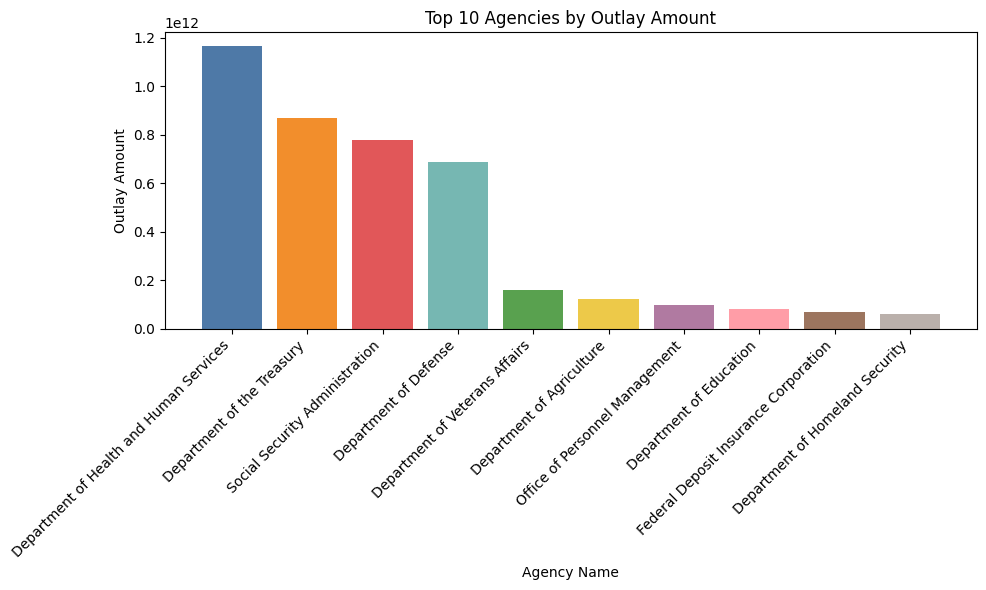

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
outlay_pd_df = outlay_df.toPandas()

# Define colors
colors = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F', '#EDC949', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AB']


plt.figure(figsize=(10, 6))
for i, agency in enumerate(outlay_pd_df['agency_name']):
    plt.bar(agency, outlay_pd_df.loc[i, 'outlay_amount'], color=colors[i % len(colors)])
plt.title('Top 10 Agencies by Outlay Amount')
plt.xlabel('Agency Name')
plt.ylabel('Outlay Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Request 6:Top 10 Agencies by Budget Authority Amount

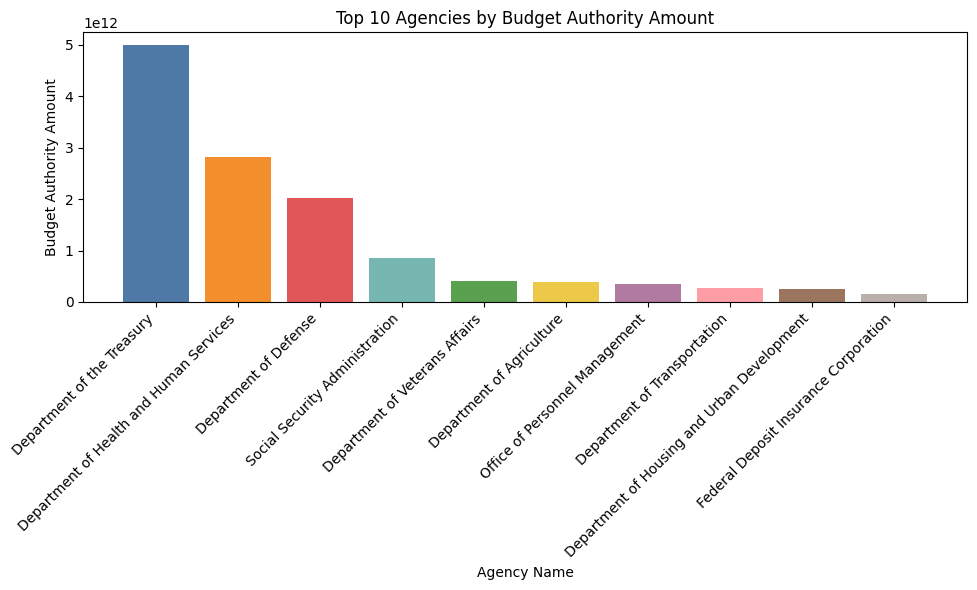

In [ ]:


# Convert Spark DataFrame to Pandas DataFrame
bauthority_pd_df = bauthority_df.toPandas()


colors = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F', '#EDC949', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AB']

# Plotting
plt.figure(figsize=(10, 6))
for i, agency in enumerate(bauthority_pd_df['agency_name']):
    plt.bar(agency, bauthority_pd_df.loc[i, 'budget_authority_amount'], color=colors[i % len(colors)])
plt.title('Top 10 Agencies by Budget Authority Amount')
plt.xlabel('Agency Name')
plt.ylabel('Budget Authority Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Request 7: Comparing Budget Authority Amount and Outlay Amount for Agencies with Highest Budget Authority

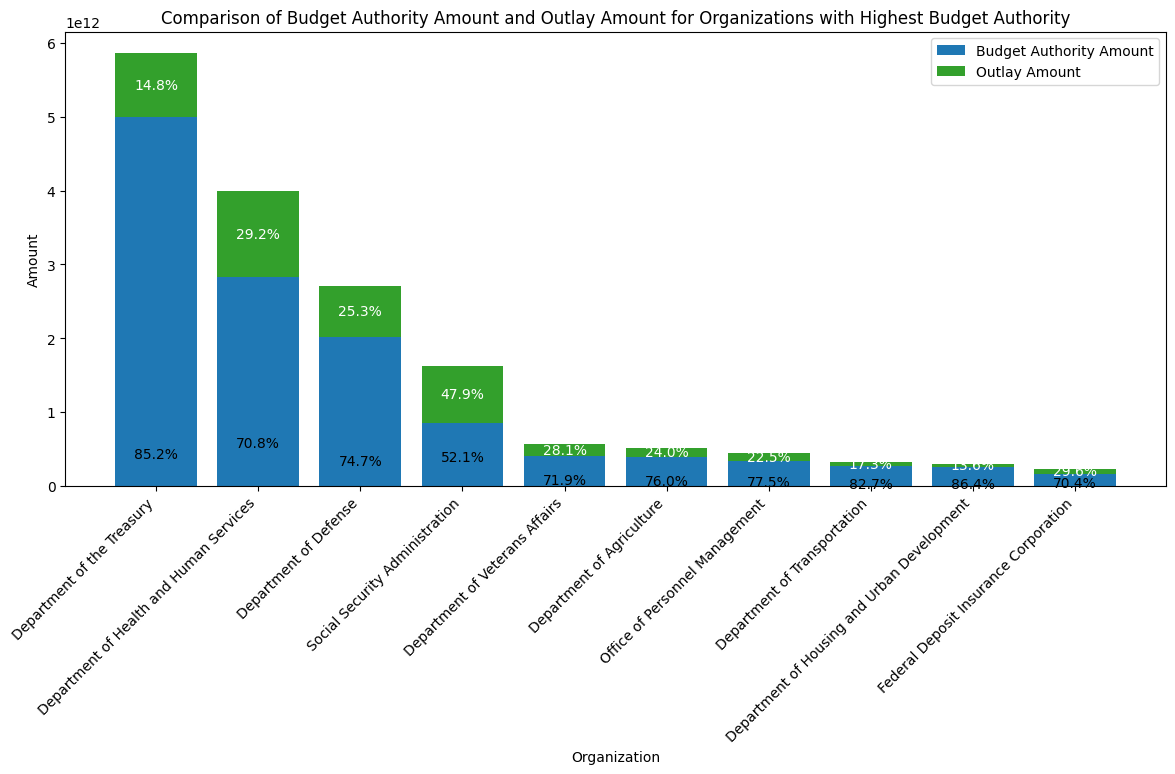

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
tmp_pd_df = df_api.toPandas()

# Sort DataFrame by budget_authority_amount in descending order
sorted_df = tmp_pd_df.sort_values(by='budget_authority_amount', ascending=False)

# Select top 10 organizations with highest budget authority
top_10_df = sorted_df.head(10)

# Define colors for each category. Blue for budget_authority_amount, Green for outlay_amount
colors = ['#1f78b4', '#33a02c']

# Create Plot

plt.figure(figsize=(12, 8))

# Create a stacked bar chart for the top 10 organizations
bars1 = plt.bar(top_10_df['agency_name'], top_10_df['budget_authority_amount'], color=colors[0], label='Budget Authority Amount')
bars2 = plt.bar(top_10_df['agency_name'], top_10_df['outlay_amount'], bottom=top_10_df['budget_authority_amount'], color=colors[1], label='Outlay Amount')

# Add labels and legend
plt.title('Comparison of Budget Authority Amount and Outlay Amount for Organizations with Highest Budget Authority')
plt.xlabel('Organization')
plt.ylabel('Amount')
plt.xticks(rotation=45, ha='right')

# Add percentage labels for outlay amount
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    total_height = height1 + height2
    remaining_budget = height1 / total_height
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() / 2, f'{remaining_budget:.1%}', ha='center', va='center', color='black')

# Add percentage labels for remaining budget authority amount
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    total_height = height1 + height2
    outlay_percentage = height2 / total_height
    plt.text(bar2.get_x() + bar2.get_width() / 2, height1 + height2 / 2, f'{outlay_percentage:.1%}', ha='center', va='center', color='white')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### Request 8: Return Total Budget Spendout Rate for 2024 so far

In [ ]:
# To calculate total spend out rate, first calculate total outlay amount and total budget authority amount
total_outlay_amount = sqlContext.sql("""
    SELECT SUM(outlay_amount) AS total_outlay_amount
    FROM tmp_dfapi
""").collect()[0]['total_outlay_amount']

total_budget_authority_amount = sqlContext.sql("""
    SELECT SUM(budget_authority_amount) AS total_budget_authority_amount
    FROM tmp_dfapi
""").collect()[0]['total_budget_authority_amount']

# Calculate total spendout rate
total_spendout_rate = 0
if total_budget_authority_amount != 0:
    total_spendout_rate = (total_outlay_amount / total_budget_authority_amount) * 100

print("Total Spendout Rate:", total_spendout_rate, "%")

Total Spendout Rate: 32.09324878638968 %
